In [1]:
import os, sys
import argparse
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import requests
from requests.auth import HTTPBasicAuth
from datetime import datetime
import shutil
import json 
from glob import glob
from osgeo import gdal
import numpy as np
from rasterstats import zonal_stats
import pdb
import rasterio as rio
import time
from csv import writer

ModuleNotFoundError: No module named 'pandas'

# Functions

In [46]:
def get_tiles(shpfl):
    shp = gpd.read_file(shpfl)
    shp = shp.to_crs('epsg:4326')
    xmin, ymin, xmax, ymax = shp.total_bounds
    bounds = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin)])
    mgs = gpd.read_file(r"C:\Users\tangz\Desktop\Base_Data\Sentinel-2-Shapefile-Index\sentinel_2_index_shapefile.shp")
    # intersect with MGS
    mgs_intersect = mgs[mgs.intersects(bounds)]
    # get tile names 
    tiles = mgs_intersect['Name'].values.tolist()
    print('Tiles to download: {}'.format(len(tiles)))
    return tiles

In [48]:
def list_hls(sensors,sdate,edate,tiles):
    """Function downloading HLS Image in batch;
    itype: dtype     --'S10','L30','S30';
           strtime   --acquired starting time of data 'YYYYMMDD'
           endtime   --acquired ending time of data 'YYYYMMDD'
           tile      --tile number of image           
    rtype: list of file links"""
    ## Bands of interest for each sensor type:
    #pdb.set_trace()
    sb = {}
    sb['L30'] = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B10', 'B11', 'Fmask']
    sb['S30'] = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07','B08', 'B8A', 'B11', 'B12', 'Fmask']

    ## TODO: need to figure out how to separate L30 and S30 queries
    sensors = ['L30', 'S30']
    cid = {}
    cid['S30'] = 'collection_concept_id=C2021957295-LPCLOUD'
    cid['L30'] = 'collection_concept_id=C2021957657-LPCLOUD'

    linklist = []
    print('Creating download list')
    for tile in tiles:
        # Request list of file names
        sq = []
        for sensor in sensors:
            sq.append(cid[sensor])
        squeary = '&'.join(sq)
        ## TODO: need to add pagination
        query = "https://cmr.earthdata.nasa.gov/search/granules.json?{}&temporal={}T00:00:00Z,{}T23:59:59Z&attribute[]=string,MGRS_TILE_ID,{}&page_size=2000".format(squeary, sdate, edate, tile)
        ###"https://cmr.earthdata.nasa.gov/search/granules.json?collection_concept_id=C2021957295-LPCLOUD&collection_concept_id=C2021957657-LPCLOUD&temporal=2021-07-01T00:00:00Z,2021-09-01T23:59:59Z&attribute[MGRS_TILE_ID]="+tile
        with requests.get(query, timeout=30) as response:
            if response.status_code == 200:
                res = json.loads(response.text)
                response.close()
                for fil in res['feed']['entry']:
                    #print(fil['links'][0]['href'])
                    for band in fil['links']:
                        if 'title' in band.keys():
                            #print(band['title'])
                            if 'Download' in band['title']:
                                lnk = band['href']
                                snsr = lnk.split('.')[6]
                                b = lnk.split('.')[-2]
                                if b in sb[snsr]:
                                    linklist.append(lnk)
            else:
                print('Bad Query')
                break

    linklist.sort()

    return linklist

In [50]:
def hls_cmask(infile):
    """Function to create cloud mask of HLS image;
    itype: directory of IMG files;
    rtype:"""
    cmask = infile.replace('fmask.tif','cmask_cs.tif')
    if not os.path.exists(cmask):
        print('Creating cloud mask: ', cmask)
        img = gdal.Open(infile)
        gt = img.GetGeoTransform()
        proj = img.GetProjection()
        xsize = img.RasterXSize
        ysize = img.RasterYSize
        nd = img.GetRasterBand(1).GetNoDataValue()
        qa = img.GetRasterBand(1).ReadAsArray()
        qa = np.array(qa, dtype = int)
        # If Cirrus or Cloud or Adjacent Cloud or Cloud Shadow:
        mask = np.bitwise_and(qa, int('00001111', 2))
        # Nodata -- Do not mask
        qa[np.where(qa == nd)] = 0
        # To mask
        qa[np.where(mask != 0)] = 1
        # Do not mask
        qa[np.where(mask == 0)] = 0
        driver = gdal.GetDriverByName('GTiff')
        output = driver.Create(cmask, xsize, ysize, 1, gdal.GDT_Byte)
        output.SetGeoTransform(gt)
        output.SetProjection(proj)
        output.GetRasterBand(1).WriteArray(qa)
        output = None
        img = None

In [51]:
def download_hls(lks, user, pword, lname):
    """Function downloading HLS Image in batch;
    itype: list of all file links  --[...]
           outdir                  --folder for downloaded image           
    rtype: """

    outdir = r'Z:\Imagery\HLS\v2.0'
    url = "https://cmr.earthdata.nasa.gov"


    sbands = {'L30': {'B02': 'blue',
                'B03': 'green',
                'B04': 'red',
                'B05': 'nir',
                'B06': 'SWIR_1',
                'B07': 'SWIR_2',
                'B10': 'thermal_infrared_1',
                'B11': 'thermal_infrared_2',
                'Fmask': 'fmask'},
            'S30': {'B02': 'blue',
                'B03': 'green',
                'B04': 'red',
                'B05': 'rededge1',
                'B06': 'rededge2',
                'B07': 'rededge3',
                'B08': 'nir',
                'B8A': 'nir8A', 
                'B11': 'SWIR_1',
                'B12': 'SWIR_2',
                'Fmask': 'fmask'}}

    if lks:
        for lk in lks:
            fname1 = os.path.basename(lk)
            dataset, sensor, tile, doy, v1, v2, band, fmt = fname1.split('.')
            fname2 = fname1.replace(band, sbands[sensor][band])
            fdir = fname1.split(band)[0][:-1]
            stile = tile.lstrip('T')
            year = doy[:4]
            tileFolder = os.path.join(outdir, sensor, year, stile)
            imgFolder = os.path.join(tileFolder, fdir)
            imgFile = os.path.join(imgFolder, fname2)
            # Create data directory if it doesn't already exist
            if not os.path.exists(imgFolder):
                os.makedirs(imgFolder)

            redo = 'yes'
            while redo == 'yes':
                print('Getting link:', lk)
                session = requests.Session()
                session.auth = (user, pword)
                auth = session.post(url)
                #response = session.get(lk, stream=True, timeout=5)
                #with session.get(lk, stream=True) as response:
                success = False
                while not success:
                    try:
                        response = session.get(lk, stream=True, timeout=100)
                        success = True
                    except Exception as e:
                        print('Error! Waiting 60 secs and re-trying...')
                        sys.stdout.flush()
                        time.sleep(60)
                if response.status_code == 200:
                    # Check if file exists/existing file is complete
                    urlsize = response.headers['Content-length']
                    temp = response.raw
                    if os.path.exists(imgFile):
                        exsize = os.path.getsize(imgFile)
                        if urlsize != str(exsize):
                            os.remove(imgFile)
                    # Download only if file does not exist or wrong file size (incomplete download)
                    if not os.path.exists(imgFile):
                        print('Downloading: ', lk)
                        # Keeps timing out
                        with open(imgFile, 'wb') as outputf:
                            shutil.copyfileobj(temp, outputf)
                        #outputf.close()
                        exsize = os.path.getsize(imgFile)
                        if urlsize == str(exsize):
                            redo = 'no'
                            print(urlsize, str(exsize))
                        else:
                            print("Faulty download", urlsize, str(exsize))
                    else: 
                        redo = 'no'
                        print('File previously downloaded')
                response.close()
            if band == 'Fmask':
                hls_cmask(imgFile)
            # append log file with completed download file name
            with open(lname, 'a', newline='') as outf:  
                wobject = writer(outf)
                wobject.writerow([imgFile])
                outf.close()

# Apply the function

In [52]:
shpfl = r"C:\Users\tangz\Desktop\US_CornSoy_ClassificationYield\GeoData\Vectors\csb_IL_2022_McLean.shp"
# shpfl = r"C:\Users\tangz\Desktop\US_CornSoy_ClassificationYield\GeoData\Vectors\csb_IL_2022.shp"
shp = gpd.read_file(shpfl)
shp.crs

<Projected CRS: PROJCS["Albers_Conic_Equal_Area",GEOGCS["NAD83",DA ...>
Name: Albers_Conic_Equal_Area
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [57]:
# whether a file exists or not
def file_exists(file_path):
    if os.path.exists(file_path):
        return True
    else:
        return False
file_exists(r"D:\Imagery\HLSv2.0\L30\2022\16TBK\HLS.L30.T16TBK.2022007T164155.v2.0\HLS.L30.T16TBK.2022007T164155.v2.0.fmask.tif" )

True

In [ ]:
hls_cmask(infile =r"D:\Imagery\HLSv2.0\L30\2022\16TBK\HLS.L30.T16TBK.2022007T164155.v2.0\HLS.L30.T16TBK.2022007T164155.v2.0.fmask.tif" )

In [ ]:
from osgeo import gdal

In [2]:
infile = r"D:\Imagery\HLSv2.0\L30\2022\16TBK\HLS.L30.T16TBK.2022007T164155.v2.0\HLS.L30.T16TBK.2022007T164155.v2.0.fmask.tif"
cmask =  infile.replace('fmask.tif','cmask_cs.tif')
cmask

'D:\\Imagery\\HLSv2.0\\L30\\2022\\16TBK\\HLS.L30.T16TBK.2022007T164155.v2.0\\HLS.L30.T16TBK.2022007T164155.v2.0.cmask_cs.tif'

In [31]:
hls_cmask(infile)

Creating cloud mask:  D:\Imagery\HLSv2.0\L30\2022\16TBK\HLS.L30.T16TBK.2022007T164155.v2.0\HLS.L30.T16TBK.2022007T164155.v2.0.cmask_cs.tif


TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [72]:
infile

'D:\\Imagery\\HLSv2.0\\L30\\2022\\16TBK\\HLS.L30.T16TBK.2022007T164155.v2.0\\HLS.L30.T16TBK.2022007T164155.v2.0.fmask.tif'

In [5]:
import gdal

ModuleNotFoundError: No module named 'gdal'

In [3]:
img = gdal.Open(infile)
gt = img.GetGeoTransform()
proj = img.GetProjection()
xsize = img.RasterXSize
ysize = img.RasterYSize
nd = img.GetRasterBand(1).GetNoDataValue()
qa = img.GetRasterBand(1).ReadAsArray()
qa = np.array(qa, dtype = int)

NameError: name 'gdal' is not defined

In [63]:
band = img.GetRasterBand(1)
print("Data type:", gdal.GetDataTypeName(band.DataType))


Data type: Byte


In [64]:
qa = band.ReadAsArray()


In [75]:
# Read a small chunk of the raster
chunk = band.ReadAsArray(0, 0, 100, 100)  # Adjust the size as needed
print(chunk)


None


In [41]:
band_num = 1
if band_num <= num_bands:
    band = img.GetRasterBand(band_num)
    if band is None:
        print(f"Failed to get band {band_num}.")
    else:
        qa = band.ReadAsArray()

In [74]:
gdal.SetConfigOption("GDAL_CACHEMAX", "512")  # Set cache size to 512MB


In [73]:
driver = gdal.GetDriverByName('GTiff')  # Replace 'GTiff' with the appropriate driver for your raster format
img = driver.Open(infile, gdal.GA_ReadOnly)


AttributeError: type object 'object' has no attribute '__getattr__'

In [40]:
num_bands = img.RasterCount
print(f"The raster has {num_bands} bands.")


The raster has 1 bands.


In [27]:
img = gdal.Open(infile)

In [26]:
rio.open(infile)

<open DatasetReader name='D:/Imagery/HLSv2.0/L30/2022/16TBK/HLS.L30.T16TBK.2022007T164155.v2.0/HLS.L30.T16TBK.2022007T164155.v2.0.fmask.tif' mode='r'>

In [28]:
gt = img.GetGeoTransform()

In [9]:
tiles = get_tiles(shpfl)
linklist = list_hls(sensors = ['L30', 'S30'], tiles = tiles, start_date = '2019-01-01', end_date = '2019-01-10')

Tiles to download: 4


TypeError: list_hls() got an unexpected keyword argument 'start_date'

In [5]:
mgs = gpd.read_file(r"C:\Users\tangz\Desktop\Base_Data\Sentinel-2-Shapefile-Index\sentinel_2_index_shapefile.shp")
mgs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
shp.to_crs('epsg:4326')

<Axes: >

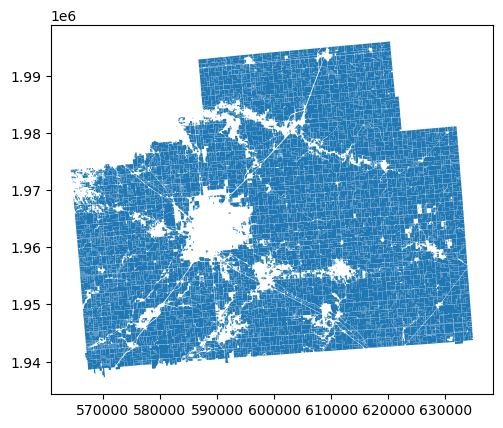

In [19]:
shp.plot()

In [5]:
get_tiles(shpfl)

Tiles to download: 4


['16TBK', '16TBL', '16TCK', '16TCL']